In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy
import matplotlib.gridspec as gridspec

In [2]:
# select the data file to load
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

In [3]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# if there is no beam file present, then we can create one

#beam_freqs = np.linspace(0, 384e6, 384)
#uvb = hp.PSpecBeamGauss(fwhm=0.2117, beam_freqs=beam_freqs)

In [4]:
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [5]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [47]:
fmax=650
fmin=550
num_delays = np.arange(20,fmax-fmin,2)
# Specify which baselines to include
baselines = [(1,121)]
std_n_true = []
std_n_false = []
std_true_all = []
std_false_all = []
mean_n_true = []
mean_n_false = []

for num_d in num_delays:
    
    uvp = ds.pspec(baselines,baselines,(0, 1), [('xx', 'xx')], spw_ranges=[(fmin,fmax)],exact_norm = True, n_dlys=num_d, input_data_weight='identity',norm='I', taper='blackman-harris', verbose=False)
    key = (0, ((1,121),(1,121)), 'xx')
    power = np.abs(np.real(uvp.get_data(key)))
    std_n_true.append(np.std((power.T[int(2*num_d/3),:])))
    mean_n_true.append(np.mean(np.mean(power.T[int(2*num_d/3):num_d,:],axis=1)))
    #std_n_true.append(np.std((power.T[:,:]),axis=0))
    std_true_all.append(np.std((power.T[int(2*num_d/3):num_d,:]).flatten()))
    
for num_d in num_delays:
    uvp = ds.pspec(baselines,baselines,(0, 1), [('xx', 'xx')], spw_ranges=[(fmin,fmax)],exact_norm = False, n_dlys=num_d, input_data_weight='identity',norm='I', taper='blackman-harris', verbose=False)
    key = (0, ((1,121),(1,121)), 'xx')
    power = np.abs(np.real(uvp.get_data(key)))
    #std_n_false.append(np.std((power.T[int(2*num_d/3),:])))
    std_n_false.append(np.std((power.T[int(2*num_d/3),:])))
    mean_n_false.append(np.mean(np.mean(power.T[int(2*num_d/3):num_d,:],axis=1)))
    std_false_all.append(np.std((power.T[int(2*num_d/3):num_d,:]).flatten()))


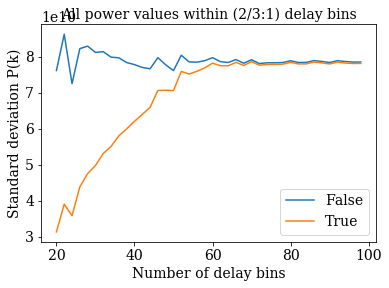

In [48]:
#plt.plot(num_delays,np.array(std_n_true)-np.array(std_n_false))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.plot(num_delays,np.array(std_false_all),label="False")
plt.plot(num_delays,np.array(std_true_all),label="True")
plt.ylabel("Standard deviation P(k)",fontsize=14)
plt.xlabel("Number of delay bins",fontsize=14)
plt.title("All power values within (2/3:1) delay bins",fontsize=14)
plt.legend(loc='best',prop={'size': 14})
#plt.savefig("std_hist_vs_delay_bins.pdf")
plt.show()